# Laboratorio 6

## Wine classification

1. Load the dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine
wine_dataset = load_wine()
wine_X = wine_dataset["data"]
wine_y = wine_dataset["target"]
wine_feature_names = wine_dataset["feature_names"]

In [3]:
print(wine_X.shape)
print(wine_y.shape)
print(wine_feature_names)

(178, 13)
(178,)
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [4]:
wine_X[np.isnan(wine_X)]

array([], dtype=float64)

In [5]:
from collections import Counter

In [6]:
Counter(wine_y)

Counter({0: 59, 1: 71, 2: 48})

2. Create a DecisionTreeClassifier object with the default configuration

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
clf = DecisionTreeClassifier()

clf = clf.fit(wine_X, wine_y)

3. Now that you have created a tree, you can visualize it

In [9]:
from sklearn.tree import plot_tree

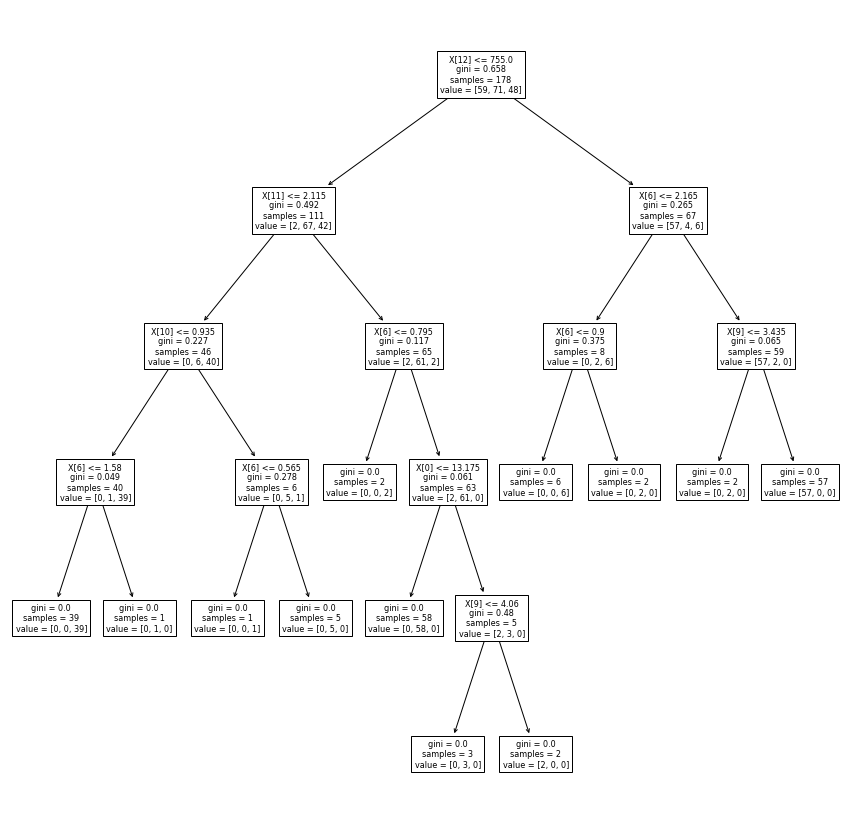

In [10]:
plt.figure(figsize=(15,15))
_ = plot_tree(clf)

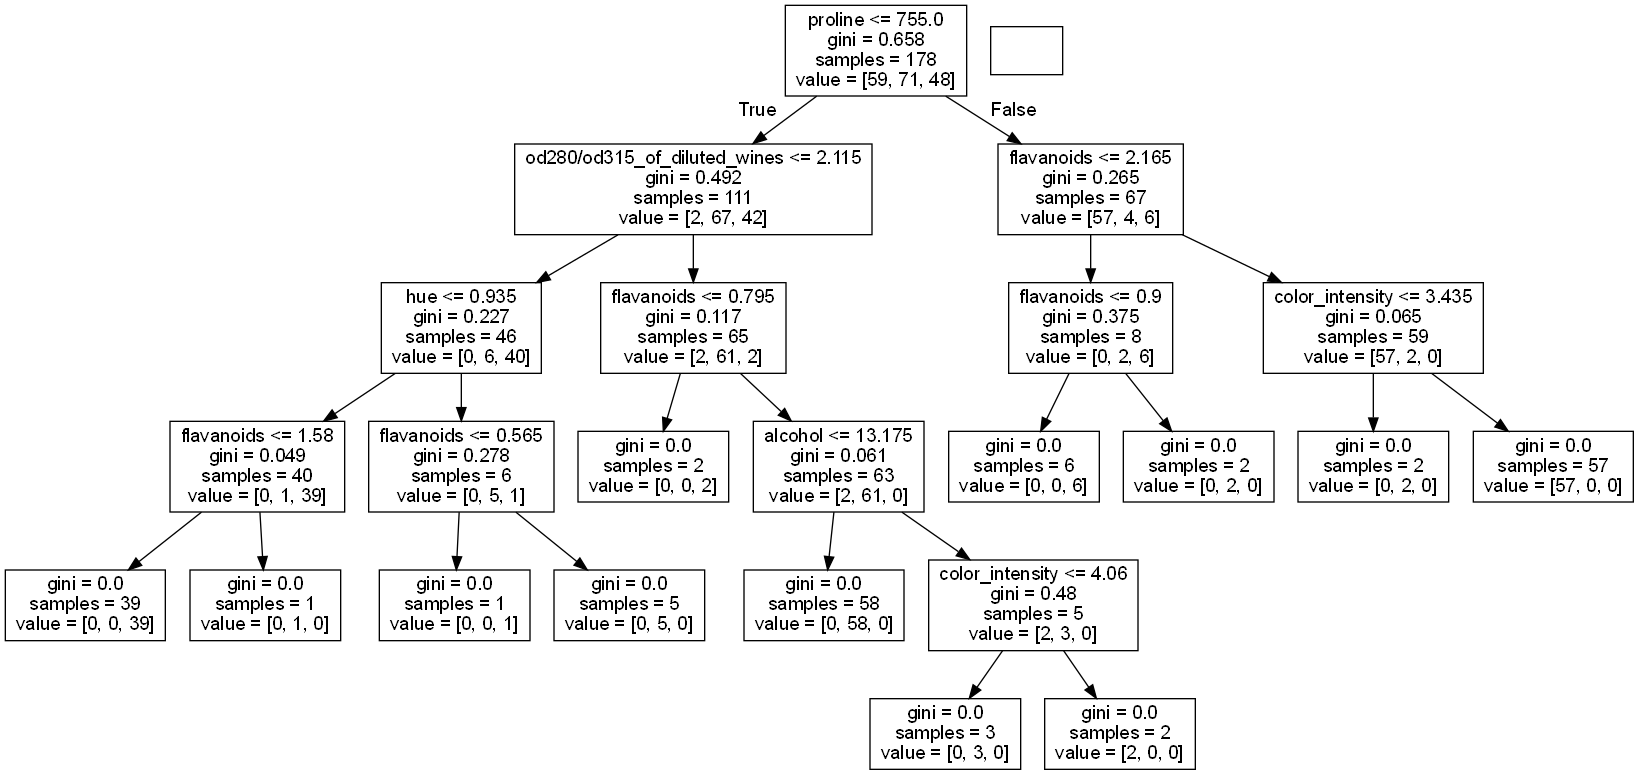

In [11]:
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz
# here, features is a list of names, one for each feature
# this makes the resulting tree visualization more comprehensible
dot_code = export_graphviz(clf, feature_names=wine_feature_names)
graph = pydot.graph_from_dot_data(dot_code)
Image(graph[0].create_png())

In [12]:
from sklearn.metrics import accuracy_score 

accuracy_score(y_true=wine_y, y_pred=clf.predict(wine_X))

1.0

5. Now, we can split our dataset into a training set and a test set

In [13]:
from sklearn.model_selection import train_test_split

wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X, wine_y, train_size=.8, stratify = wine_y)

print(wine_X_train.shape) 
print(wine_X_test.shape) 
print(wine_y_train.shape) 
print(wine_y_test.shape) 

(142, 13)
(36, 13)
(142,)
(36,)


In [14]:
clf2 = DecisionTreeClassifier()

clf2.fit(wine_X_train, wine_y_train)

DecisionTreeClassifier()

In [15]:
wine_y_pred = clf2.predict(wine_X_test)

accuracy_score(y_true=wine_y_test, y_pred=clf2.predict(wine_X_test))

0.8888888888888888

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [17]:
print(confusion_matrix(wine_y_test,wine_y_pred))
print(precision_score(wine_y_test,wine_y_pred,average=None))
print(recall_score(wine_y_test,wine_y_pred,average=None))
print(f1_score(wine_y_test,wine_y_pred,average=None))
print(classification_report(wine_y_test,wine_y_pred))

[[11  1  0]
 [ 0 12  2]
 [ 0  1  9]]
[1.         0.85714286 0.81818182]
[0.91666667 0.85714286 0.9       ]
[0.95652174 0.85714286 0.85714286]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.86      0.86      0.86        14
           2       0.82      0.90      0.86        10

    accuracy                           0.89        36
   macro avg       0.89      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36



7. you will define a set of possible configurations and, for each configuration, build a classifier

In [18]:
from sklearn.model_selection import ParameterGrid
params = {
    "max_depth": [None, 2, 4, 8],
    "splitter": ["best", "random"],
    "max_depth": [None, 2, 3, 4, 5],
    "min_impurity_decrease": [0, .01, .03, .07, .09, .11]
}

metrics = []

for config in ParameterGrid(params):
    clf3 = DecisionTreeClassifier(**config)
    clf3.fit(wine_X_train, wine_y_train)
    metrics.append({
        'config' : config,
        'results' : accuracy_score(wine_y_test,clf3.predict(wine_X_test))
    })
    # metrics.append(accuracy_score(wine_y_test,clf3.predict(wine_X_test)))

metrics


[{'config': {'max_depth': None,
   'min_impurity_decrease': 0,
   'splitter': 'best'},
  'results': 0.8888888888888888},
 {'config': {'max_depth': None,
   'min_impurity_decrease': 0,
   'splitter': 'random'},
  'results': 0.9722222222222222},
 {'config': {'max_depth': None,
   'min_impurity_decrease': 0.01,
   'splitter': 'best'},
  'results': 0.8055555555555556},
 {'config': {'max_depth': None,
   'min_impurity_decrease': 0.01,
   'splitter': 'random'},
  'results': 0.9722222222222222},
 {'config': {'max_depth': None,
   'min_impurity_decrease': 0.03,
   'splitter': 'best'},
  'results': 0.9166666666666666},
 {'config': {'max_depth': None,
   'min_impurity_decrease': 0.03,
   'splitter': 'random'},
  'results': 0.8611111111111112},
 {'config': {'max_depth': None,
   'min_impurity_decrease': 0.07,
   'splitter': 'best'},
  'results': 0.8611111111111112},
 {'config': {'max_depth': None,
   'min_impurity_decrease': 0.07,
   'splitter': 'random'},
  'results': 0.7777777777777778},
 {'con

8. K-fold validation

In [19]:
from sklearn.model_selection import KFold
# Split the datasets into two:
# - X_train_valid: the dataset used for the k-fold cross-validation
# - X_test: the dataset used for the final testing (this will NOT
# be seen by the classifier during the training/validation phases)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(wine_X, wine_y, train_size=.8, stratify = wine_y)
kf = KFold(5) # 5-fold cross-validation 
# X and y are the arrays to be split

accuracies = []
for config in ParameterGrid(params):
    clf_accuracies = []
    counts = []
    for train_indices, valid_indices in kf.split(X_train_valid):
        X_train = X_train_valid[train_indices]
        y_train = y_train_valid[train_indices]
        X_valid = X_train_valid[valid_indices]
        y_valid = y_train_valid[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 
        
        clf = DecisionTreeClassifier(**config)
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_valid, clf.predict(X_valid))
        clf_accuracies.append(acc)
    accuracies.append(np.average(clf_accuracies, weights=counts))

In [20]:
best_config = list(ParameterGrid(params))[np.argmax(accuracies)]
clf = DecisionTreeClassifier(**best_config)
clf.fit(X_train_valid, y_train_valid)
accuracy_score(y_test, clf.predict(X_test))

0.9444444444444444

## Synthetic dataset

Load the synthetic dataset you have previously downloaded

In [21]:
df_synth = pd.read_csv('2d-synthetic.csv')

In [22]:
df_synth

,x0,x1,label
0,9.833469,0.319565,0
1,1.801045,8.705072,0
2,4.423918,3.488906,1
3,0.280730,2.689037,1
4,5.999494,9.167512,0
...,...,...,...
495,4.995458,8.437083,0
496,6.636632,9.931535,0
497,6.373259,8.098388,0
498,1.230331,7.169844,1


<AxesSubplot:xlabel='x0', ylabel='x1'>

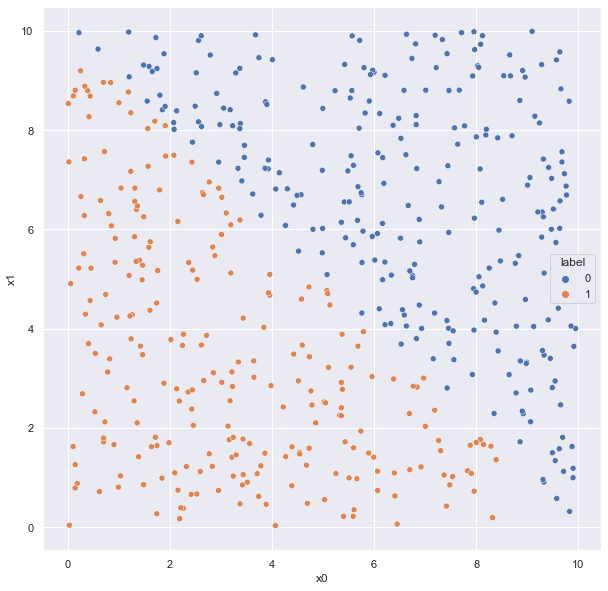

In [23]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(data=df_synth, x='x0', y='x1', hue='label')

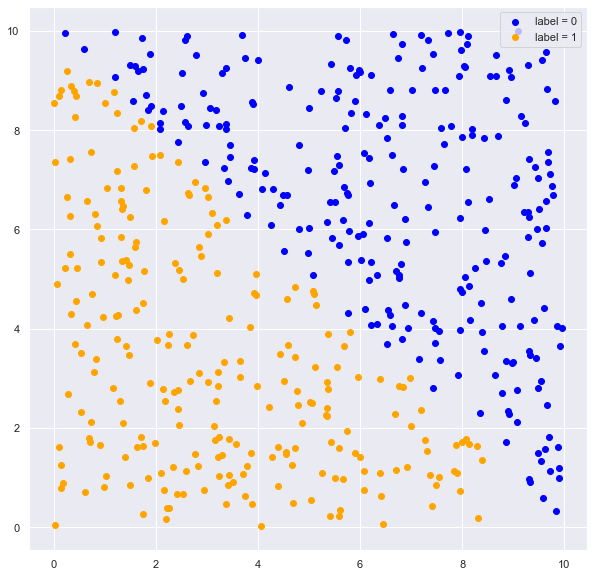

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_synth['x0'].loc[df_synth['label']==0], df_synth['x1'].loc[df_synth['label']==0], c='blue', label='label = 0')
ax.scatter(df_synth['x0'].loc[df_synth['label']==1], df_synth['x1'].loc[df_synth['label']==1], c='orange', label='label = 1')
ax.legend()

2. Build a “default” decision tree using the entire dataset, then visualize the learned model.

In [25]:
clf_synth = DecisionTreeClassifier()

synth_X = df_synth.iloc[:,[0,1]].to_numpy()
synth_y = df_synth.iloc[:,2].to_numpy()

# synth_X_train, synth_y_train, synth_X_test, synth_y_test = train_test_split(synth_X, synth_y, stratify=synth_y, train_size=0.8)

# clf_synth = clf_synth.fit(synth_X_train, synth_y_train)
clf_synth = clf_synth.fit(synth_X, synth_y)

# accuracy_score(synth_y_test, clf_synth.predict(synth_X_test))

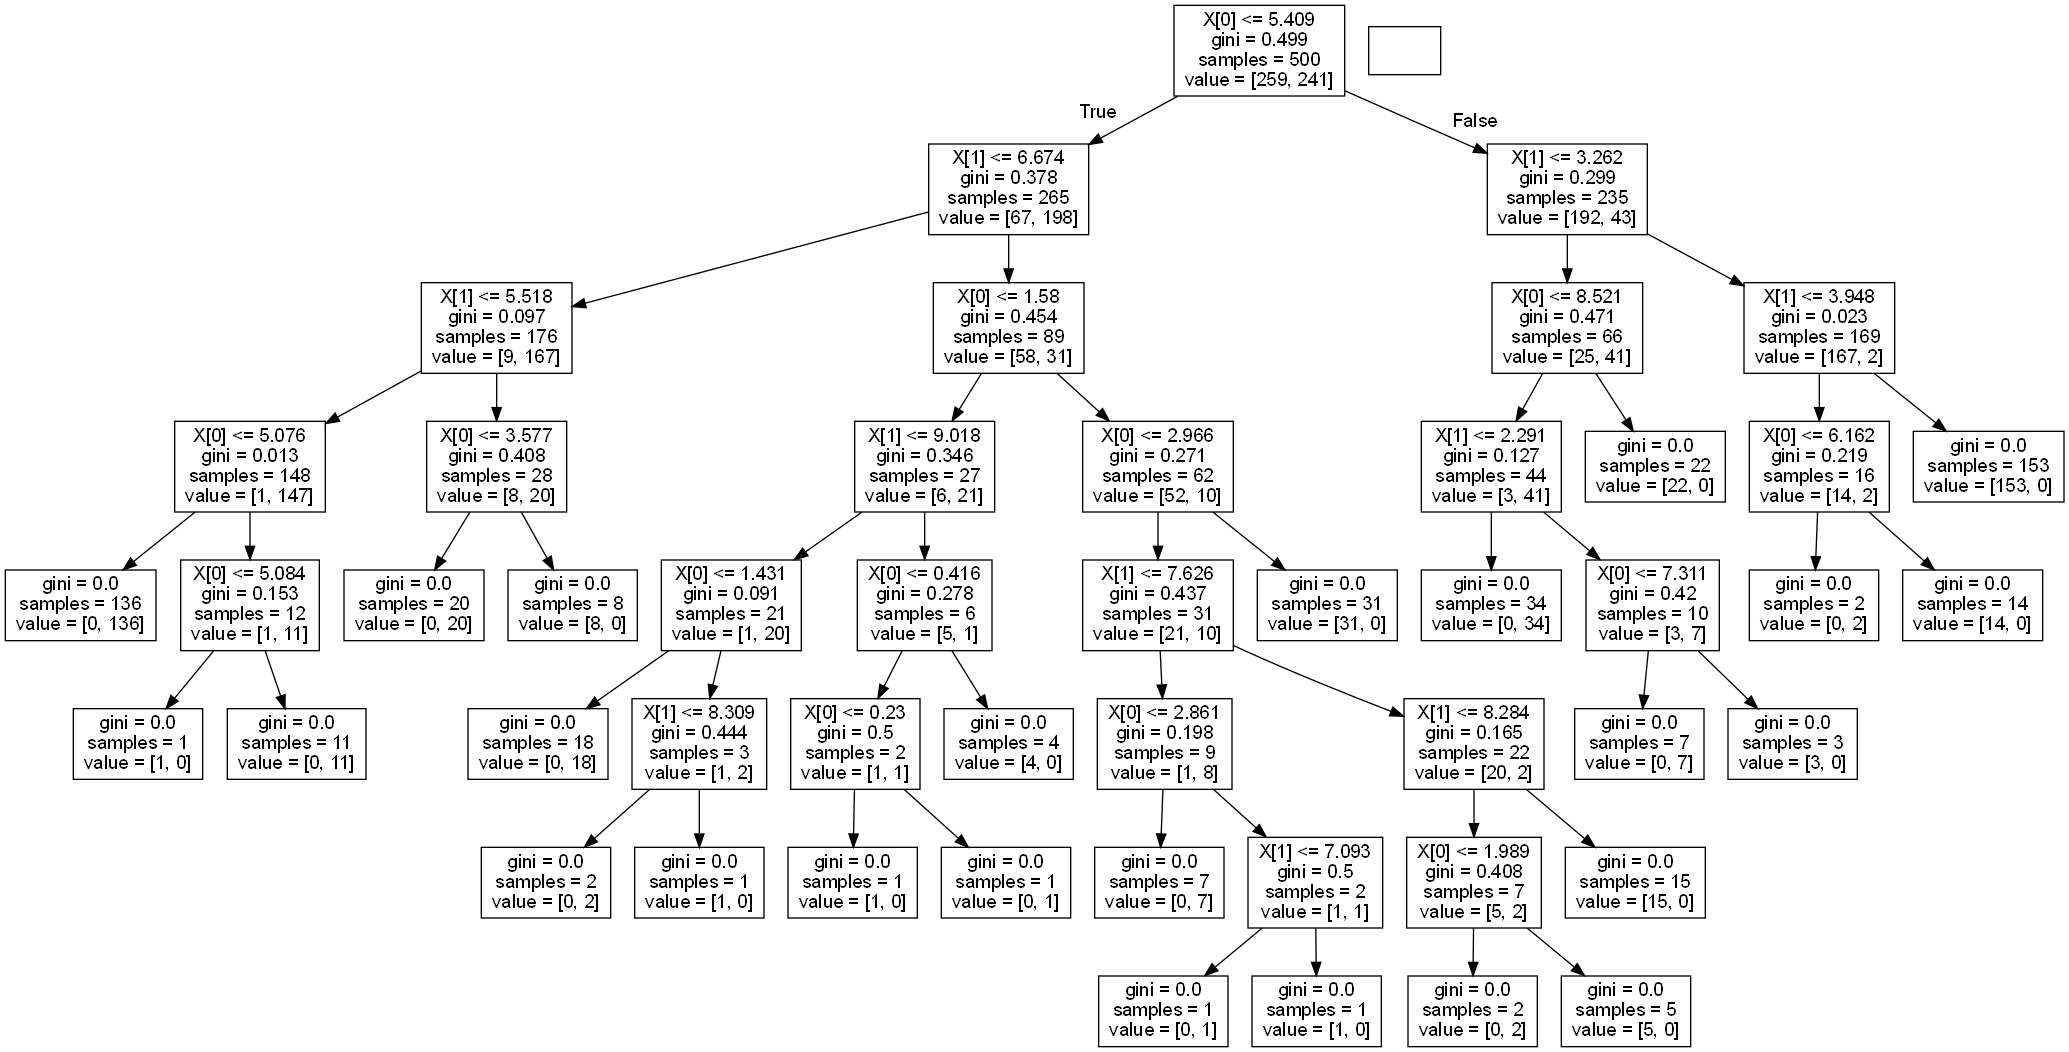

In [26]:
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz
# here, features is a list of names, one for each feature
# this makes the resulting tree visualization more comprehensible
dot_code = export_graphviz(clf_synth)
graph = pydot.graph_from_dot_data(dot_code)
Image(graph[0].create_png())

3. Identify a preprocessing step that would make the decision tree “correctly” approach this problem

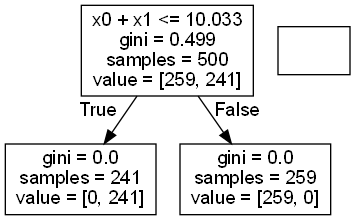

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

new_X = (df_synth.iloc[:,0].to_numpy() + df_synth.iloc[:,1].to_numpy()).reshape(-1,1)
new_y = df_synth.iloc[:,2].to_numpy().reshape(-1,1)

clf = DecisionTreeClassifier()
clf.fit(new_X,synth_y)

dot_code = export_graphviz(clf, feature_names=["x0 + x1"])
graph = pydot.graph_from_dot_data(dot_code)
Image(graph[0].create_png()) 

## Random Forest

1. Load the MNIST dataset into memory

In [28]:
from sklearn.datasets import fetch_openml
dataset = fetch_openml("mnist_784")
X = dataset["data"]
y = dataset["target"]

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=1/7)

for train_indices, test_indeces in sss.split(X, y):
    X_train, y_train = X.values[train_indices], y.values[train_indices]
    X_test, y_test = X.values[test_indeces], y.values[test_indeces]
    

2. Train a single decision tree (with the default parameters) on the training set, then compute its accuracy on the test set

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))

0.8734

3. You will implement your own version of a random forest

In [32]:
from scipy.stats import mode

class MyRandomForestClassifier():
    def __init__(self, n_estimators, max_features):
        self.trees = [DecisionTreeClassifier(max_features=max_features) for _ in range(n_estimators)]

    '''train the trees of this random forest using subsets of X (and y)'''
    def fit(self, X, y):
        for tree in self.trees:
            subset_indeces = np.random.choice(X.shape[0],size=X.shape[0],replace=True)
            tree.fit(X=X[subset_indeces], y=y[subset_indeces])
            # print(f'Feature considerate {tree.n_features_in_}')

    '''predict the label for each point in X'''
    def predict(self, X):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        predictions = np.array(predictions)
        return mode(predictions).mode

In [33]:
mrfc = MyRandomForestClassifier(20, 'sqrt')

mrfc.fit(X_train, y_train)

results = mrfc.predict(X_test)

# results.mode

In [34]:
accuracy_score(y_true=y_test, y_pred=results.squeeze())

0.9605

In [35]:
import tqdm

In [36]:
for i in tqdm.tqdm(range(10,101,10)):
    
    mrfc = MyRandomForestClassifier(i, 'sqrt')

    mrfc.fit(X_train, y_train)

    results = mrfc.predict(X_test)

    print(accuracy_score(y_true=y_test, y_pred=results.squeeze()))

 10%|█         | 1/10 [00:10<01:33, 10.37s/it]

0.9487


 20%|██        | 2/10 [00:29<02:05, 15.68s/it]

0.9604


 30%|███       | 3/10 [00:58<02:32, 21.84s/it]

0.9635


 40%|████      | 4/10 [01:39<02:55, 29.29s/it]

0.9662


 50%|█████     | 5/10 [02:32<03:09, 37.92s/it]

0.9672


 60%|██████    | 6/10 [03:56<03:33, 53.32s/it]

0.9682


 70%|███████   | 7/10 [05:38<03:28, 69.34s/it]

0.9695


 80%|████████  | 8/10 [07:35<02:49, 84.61s/it]

0.9681


 90%|█████████ | 9/10 [09:48<01:39, 99.82s/it]

0.9702


100%|██████████| 10/10 [12:26<00:00, 74.65s/it] 

0.9705


In [37]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])

rng = np.random.default_rng()

rng.choice(a,2)

array([[ 1,  2,  3,  4],
       [ 9, 10, 11, 12]])

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
for estimator in tqdm.tqdm(range(5,101,5)):
    rfc = RandomForestClassifier(estimator, max_features='sqrt', n_jobs=-2)

    rfc.fit(X_train, y_train)

    print(accuracy_score(y_true=y_test, y_pred=rfc.predict(X_test)))

  5%|▌         | 1/20 [00:01<00:25,  1.37s/it]

0.9193


 10%|█         | 2/20 [00:03<00:34,  1.89s/it]

0.9474


 15%|█▌        | 3/20 [00:07<00:43,  2.58s/it]

0.9571


 20%|██        | 4/20 [00:11<00:51,  3.19s/it]

0.9601


 25%|██▌       | 5/20 [00:16<00:58,  3.92s/it]

0.9631


 30%|███       | 6/20 [00:22<01:06,  4.73s/it]

0.9657


 35%|███▌      | 7/20 [00:29<01:08,  5.26s/it]

0.9634


 40%|████      | 8/20 [00:36<01:10,  5.83s/it]

0.9677


 45%|████▌     | 9/20 [00:43<01:09,  6.36s/it]

0.9692


 50%|█████     | 10/20 [00:50<01:05,  6.57s/it]

0.9683


 55%|█████▌    | 11/20 [00:57<01:00,  6.76s/it]

0.9703


 60%|██████    | 12/20 [01:05<00:56,  7.01s/it]

0.9686


 65%|██████▌   | 13/20 [01:14<00:53,  7.69s/it]

0.9706


 70%|███████   | 14/20 [01:23<00:47,  7.95s/it]

0.9681


 75%|███████▌  | 15/20 [01:32<00:42,  8.44s/it]

0.9701


 80%|████████  | 16/20 [01:43<00:36,  9.13s/it]

0.9686


 85%|████████▌ | 17/20 [01:55<00:29,  9.90s/it]

0.9705


 90%|█████████ | 18/20 [02:09<00:22, 11.18s/it]

0.9711


 95%|█████████▌| 19/20 [02:22<00:11, 11.74s/it]

0.9713


100%|██████████| 20/20 [02:36<00:00,  7.81s/it]

0.9723


In [40]:
results = []

for estimator in tqdm.tqdm([5,10,15,20]):
    result = []

    rfc_skl = RandomForestClassifier(estimator, max_features='sqrt')
    rfc_skl.fit(X_train, y_train)

    rfc_mine = MyRandomForestClassifier(estimator, max_features='sqrt')
    rfc_mine.fit(X_train, y_train)

    result.append(estimator)

    # print(accuracy_score(y_test,rfc_skl.predict(X_test)))
    result.append(accuracy_score(y_test,rfc_skl.predict(X_test)))
    # print(accuracy_score(y_test,rfc_mine.predict(X_test).squeeze()))
    result.append(accuracy_score(y_test,rfc_mine.predict(X_test).squeeze()))

    results.append(result)

df_OUT = pd.DataFrame(results, columns=['estimator','skl_results','mine_results'])
df_OUT

100%|██████████| 4/4 [01:39<00:00, 24.96s/it]


,estimator,skl_results,mine_results
0,5,0.9210,0.9237
1,10,0.9473,0.9505
2,15,0.9542,0.9566
3,20,0.9604,0.9627


In [71]:
rfc = RandomForestClassifier(10, max_features='sqrt', verbose = 1, n_jobs=-2)
rfc.fit(X_train,y_train)
result = rfc.predict(X_test)

# tree_feature_importances = []
# for tree in rfc.estimators_:
#     tree_feature_importances.append(tree.feature_importances_)

trees_feature_importances = [tree.feature_importances_ for tree in rfc.estimators_]

trees_feature_importances = np.array(trees_feature_importances)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [72]:
MyRFC_feature_importances = trees_feature_importances.sum(axis=0) / trees_feature_importances.sum()

In [73]:
np.allclose(rfc.feature_importances_,MyRFC_feature_importances)

True

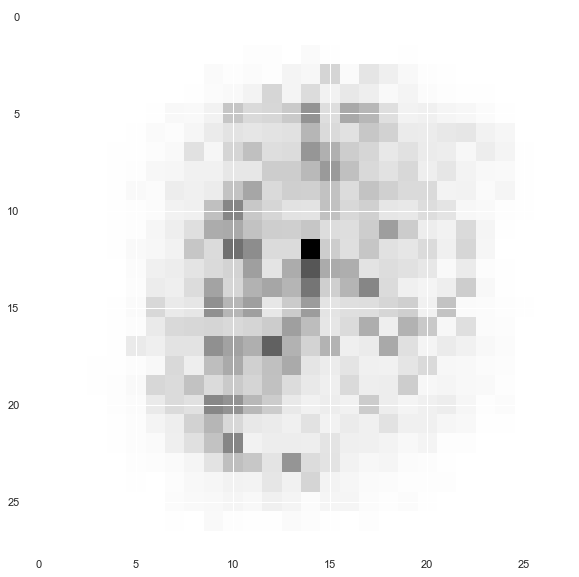

In [75]:
plt.imshow(rfc.feature_importances_.reshape(28,28), cmap='binary')